In [1]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,GlobalMaxPooling2D,Dropout

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/

In [ ]:
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ismailpromus/skin-diseases-image-dataset


Dataset URL: https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset
License(s): copyright-authors
100% 5.19G/5.19G [04:07<00:00, 21.6MB/s]
100% 5.19G/5.19G [04:07<00:00, 22.5MB/s]


In [4]:
zip_object=zipfile.ZipFile("/content/skin-diseases-image-dataset.zip","r")
zip_object.extractall("./")
zip_object.close()

In [8]:
!kaggle datasets download -d dipuiucse/monkeypoxskinimagedataset

Dataset URL: https://www.kaggle.com/datasets/dipuiucse/monkeypoxskinimagedataset
License(s): Attribution 4.0 International (CC BY 4.0)
monkeypoxskinimagedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
zip_object=zipfile.ZipFile("/content/monkeypoxskinimagedataset.zip","r")
zip_object.extractall("./")
zip_object.close()

In [ ]:
# tf.keras.preprocessing.image.load_img("/content/IMG_CLASSES/1. Eczema 1677/0_1.jpg")

In [9]:
data_dir='/content/IMG_CLASSES'
train_dir='data/train'
test_dir='data/test'

#Create directories for split data
os.makedirs(train_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)

#Split the dataset
for class_folder in os.listdir(data_dir):
  class_path=os.path.join(data_dir,class_folder)
  if os.path.isdir(class_path):
    os.makedirs(os.path.join(train_dir,class_folder),exist_ok=True)
    os.makedirs(os.path.join(test_dir,class_folder),exist_ok=True)

    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Move training images
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_folder))

        # Move testing images
    for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_folder))

In [10]:
from tensorflow.keras.applications.resnet50 import preprocess_input

training_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Replace rescale with preprocess_input
    rotation_range=7,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

training_data = training_generator.flow_from_directory(
    "/content/data/train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

Found 22176 images belonging to 12 classes.


In [11]:
validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_data = validation_generator.flow_from_directory(
    "/content/data/test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  # Typically no shuffling for validation/testing
)

Found 5549 images belonging to 12 classes.


In [12]:
training_data.class_indices

{'1. Eczema 1677': 0,
 '10. Warts Molluscum and other Viral Infections - 2103': 1,
 '2. Melanoma 15.75k': 2,
 '3. Atopic Dermatitis - 1.25k': 3,
 '4. Basal Cell Carcinoma (BCC) 3323': 4,
 '5. Melanocytic Nevi (NV) - 7970': 5,
 '6. Benign Keratosis-like Lesions (BKL) 2624': 6,
 '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 7,
 '8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 8,
 '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 9,
 'Monkeypox': 10,
 'Normal': 11}

In [13]:
n_classes=len(training_data.class_indices)
n_classes

12

In [14]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_tensor = Input(shape = (224, 224, 3)))

len(base_model.layers)
# Fine-tune specific layers
fine_tune_at=100
base_model.trainable = True    # Enable training for the base model
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False    # Freeze layers below the fine-tuning point

head_model=base_model.output
head_model = GlobalMaxPooling2D()(head_model)  # Reduce spatial dimensions
head_model = Dense(units=1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(units=n_classes, activation='softmax')(head_model)  # Final output layer

network=Model(inputs=base_model.input,outputs=head_model)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
network.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = network.fit(
    training_data,
    validation_data=test_data,
    epochs=10,                  # Train for 20 epochs
    batch_size=16,              # Batch size
    callbacks=[early_stopping]  # Use early stopping
)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1386/1386 ━━━━━━━━━━━━━━━━━━━━ 531s 357ms/step - accuracy: 0.4725 - loss: 20.8459 - val_accuracy: 0.6158 - val_loss: 13.7127
Epoch 2/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 493s 354ms/step - accuracy: 0.6578 - loss: 12.0090 - val_accuracy: 0.7315 - val_loss: 7.4522
Epoch 3/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 473s 340ms/step - accuracy: 0.7216 - loss: 6.4088 - val_accuracy: 0.7358 - val_loss: 3.8303
Epoch 4/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 479s 344ms/step - accuracy: 0.7566 - loss: 3.1943 - val_accuracy: 0.7699 - val_loss: 1.9940
Epoch 5/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 473s 340ms/step - accuracy: 0.7897 - loss: 1.7359 - val_accuracy: 0.7910 - val_loss: 1.2596
Epoch 6/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 496s 335ms/step - accuracy: 0.8135 - loss: 1.0979 - val_accuracy: 0.7895 - val_loss: 0.9701
Epoch 7/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 499s 333ms/step - accuracy: 0.8447 - loss: 0.7829 - val_accuracy: 0.8117 - val_loss: 0.7926
Epoch 8/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 450s 323ms/step - accuracy: 

In [15]:
network.save("model.h5")

In [16]:
network.save('model.keras')

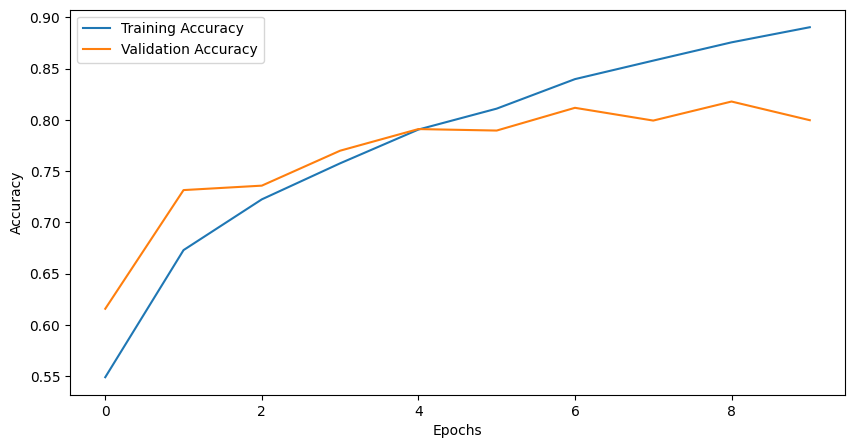

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [1]:
h=network.history.history

NameError: name 'network' is not defined